# SEC61A1
todo


In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopackets
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


In [2]:
gene_symbol = 'SEC61A1'
mane_tx_id = 'NM_013336.4'
mane_protein_id = 'NP_037468.1' # protein transport protein Sec61 subunit alpha isoform 1 isoform 1

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.20'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    cdls6_phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(cdls6_phenopackets)} phenopackets')

Loaded 18 phenopackets


In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator   = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=cdls6_phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 18/18 [00:10<00:00,  1.71individuals/s]
Loaded 18 individuals
Validated under none policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Decreased circulating IgG concentration,HP:0004315,10
Decreased specific antibody response to protein-conjugated polysaccharide vaccine,HP:0410302,10
Decreased specific antibody response to polysaccharide vaccine,HP:0410299,9
Decreased circulating IgA concentration,HP:0002720,8
Anemia,HP:0001903,7
Recurrent otitis media,HP:0000403,7
Decreased circulating total IgM,HP:0002850,7
Small for gestational age,HP:0001518,6
Elevated circulating creatinine concentration,HP:0003259,6
Recurrent lower respiratory tract infections,HP:0002783,5


In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

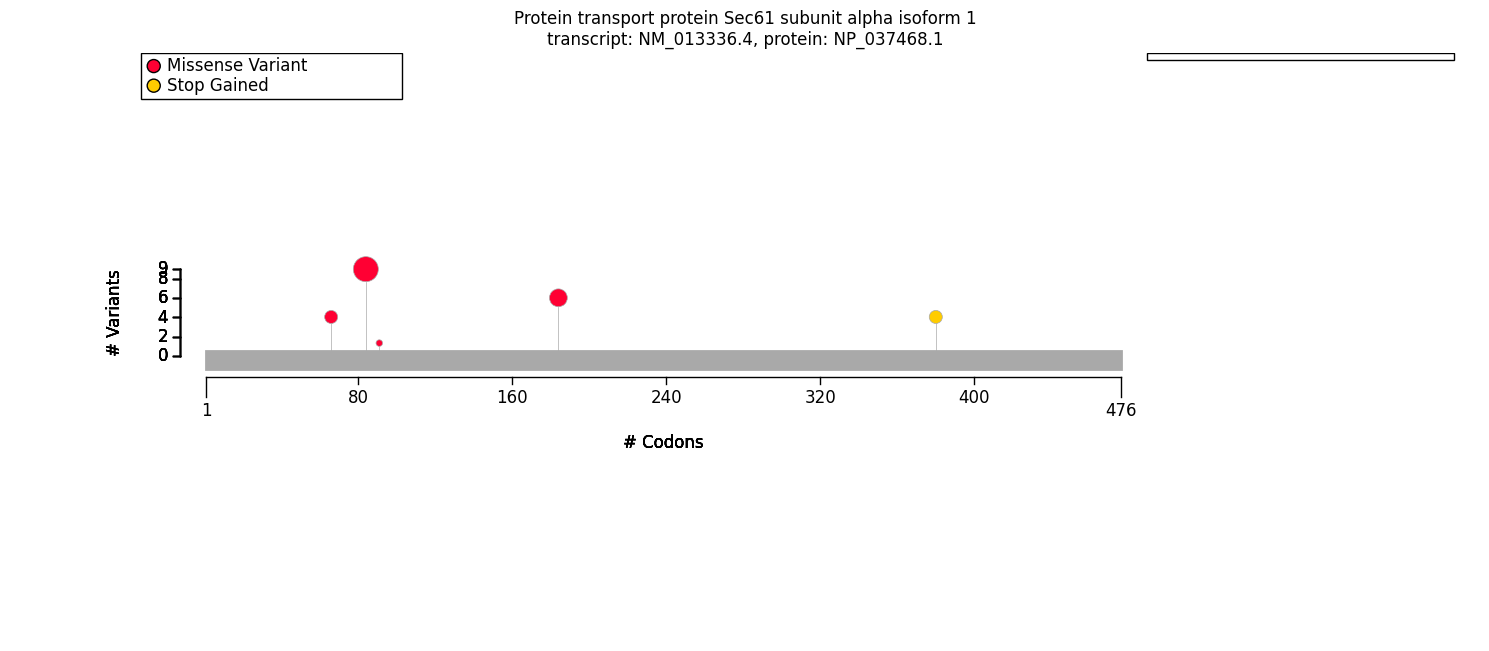

In [7]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [9]:
# 3_128056742_128056742_T_A-- p.Val85Asp
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
is_var_key = VariantPredicates.variant_key("3_128056742_128056742_T_A")
gt_predicate = monoallelic_predicate(
    a_predicate=is_var_key,
    b_predicate= ~is_var_key,
    names=('p.Val85Asp', 'Other variant')
)
gt_predicate.display_question()

'Allele group: p.Val85Asp, Other variant'

In [12]:
from gpsea.analysis.pcats import HpoTermAnalysis
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()
analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

13

In [13]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

Allele group                                       p.Val85Asp          \
                                                        Count Percent   
Recurrent lower respiratory tract infections [H...        6/6    100%   
Anemia [HP:0001903]                                       0/4      0%   
Elevated circulating creatinine concentration [...        0/4      0%   
Recurrent respiratory infections [HP:0002205]             6/6    100%   
Decreased circulating IgA concentration [HP:000...        8/9     89%   
Recurrent infections [HP:0002719]                         8/8    100%   
Decreased circulating total IgM [HP:0002850]              7/9     78%   
Recurrent upper respiratory tract infections [H...        2/2    100%   
Decreased circulating IgG concentration [HP:000...        9/9    100%   
Recurrent sinusitis [HP:0011108]                          2/9     22%   
Recurrent otitis media [HP:0000403]                       4/9     44%   
Decreased specific antibody response to protein...        8/9     89%   
Raynaud phenomenon [HP:0030880]                           2/9     22%   

Allele group                                       Other variant          \
                                                           Count Percent   
Recurrent lower respiratory tract infections [H...           0/4      0%   
Anemia [HP:0001903]                                          7/8     88%   
Elevated circulating creatinine concentration [...           6/7     86%   
Recurrent respiratory infections [HP:0002205]                1/5     20%   
Decreased circulating IgA concentration [HP:000...           0/2      0%   
Recurrent infections [HP:0002719]                            5/9     56%   
Decreased circulating total IgM [HP:0002850]                 0/2      0%   
Recurrent upper respiratory tract infections [H...           1/5     20%   
Decreased circulating IgG concentration [HP:000...           1/2     50%   
Recurrent sinusitis [HP:0011108]                             1/7     14%   
Recurrent otitis media [HP:0000403]                          3/7     43%   
Decreased specific antibody response to protein...           2/2    100%   
Raynaud phenomenon [HP:0030880]                              0/2      0%   

Allele group                                                           \
                                                   Corrected p values   
Recurrent lower respiratory tract infections [H...           0.049242   
Anemia [HP:0001903]                                          0.049242   
Elevated circulating creatinine concentration [...           0.049242   
Recurrent respiratory infections [HP:0002205]                0.049242   
Decreased circulating IgA concentration [HP:000...           0.141818   
Recurrent infections [HP:0002719]                            0.178431   
Decreased circulating total IgM [HP:0002850]                 0.202597   
Recurrent upper respiratory tract infections [H...           0.232143   
Decreased circulating IgG concentration [HP:000...           0.262626   
Recurrent sinusitis [HP:0011108]                             1.000000   
Recurrent otitis media [HP:0000403]                          1.000000   
Decreased specific antibody response to protein...           1.000000   
Raynaud phenomenon [HP:0030880]                              1.000000   

Allele group                                                  
                                                    p values  
Recurrent lower respiratory tract infections [H...  0.004762  
Anemia [HP:0001903]                                 0.010101  
Elevated circulating creatinine concentration [...  0.015152  
Recurrent respiratory infections [HP:0002205]       0.015152  
Decreased circulating IgA concentration [HP:000...  0.054545  
Recurrent infections [HP:0002719]                   0.082353  
Decreased circulating total IgM [HP:0002850]        0.109091  
Recurrent upper respiratory tract infections [H...  0.142857  
Decreased circulating IgG concentrati